imports

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

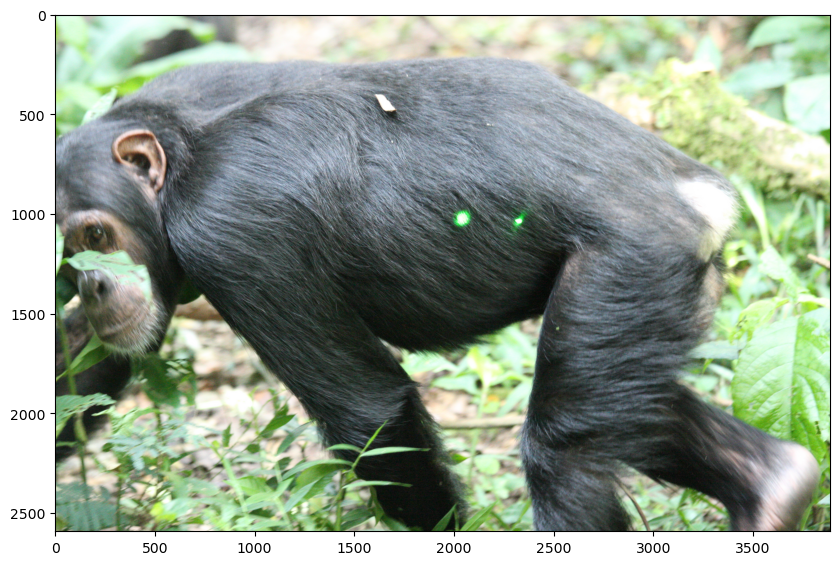

In [25]:
img = cv2.imread('../data/6_13/IMG_0335.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img)

Helper functions for displaying points, boxes, and masks

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [5]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
predictor.set_image(img)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [7]:
input_point = np.array([[2100, 600]])
input_label = np.array([1])

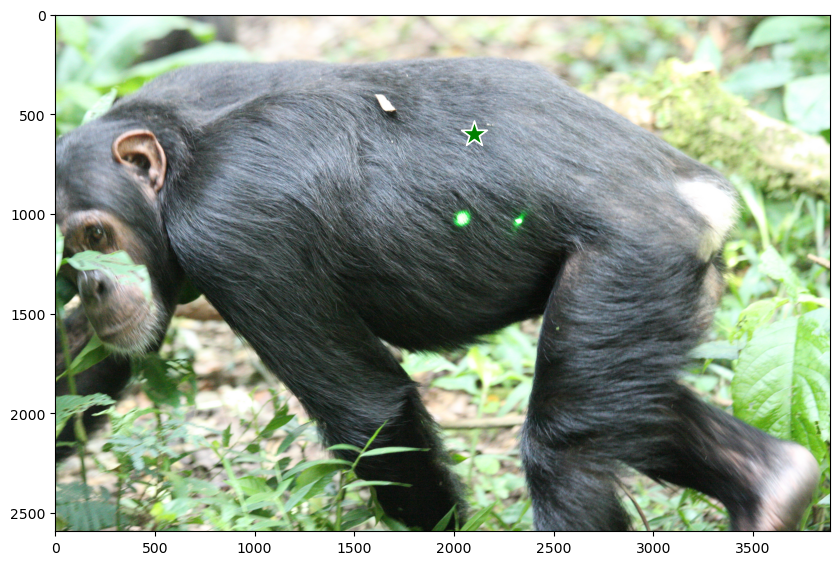

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [10]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [11]:
masks.shape  # (number_of_masks) x H x W

(1, 2592, 3888)

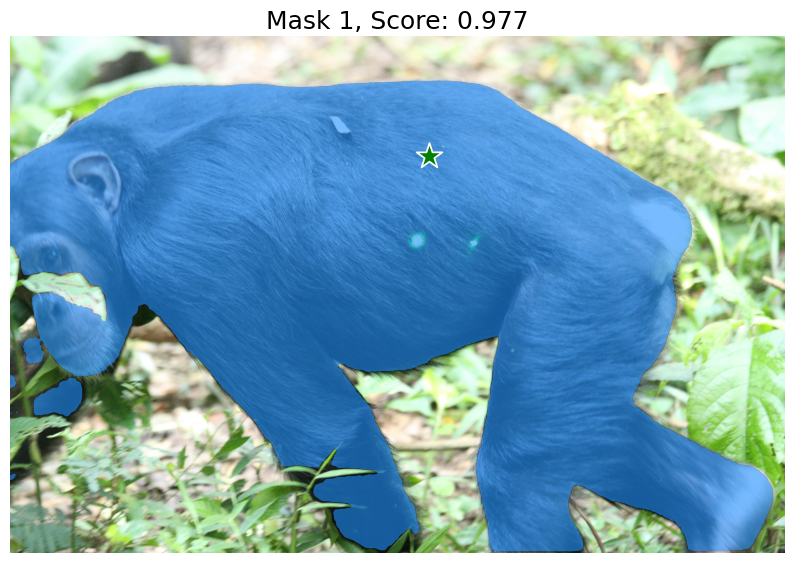

In [12]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

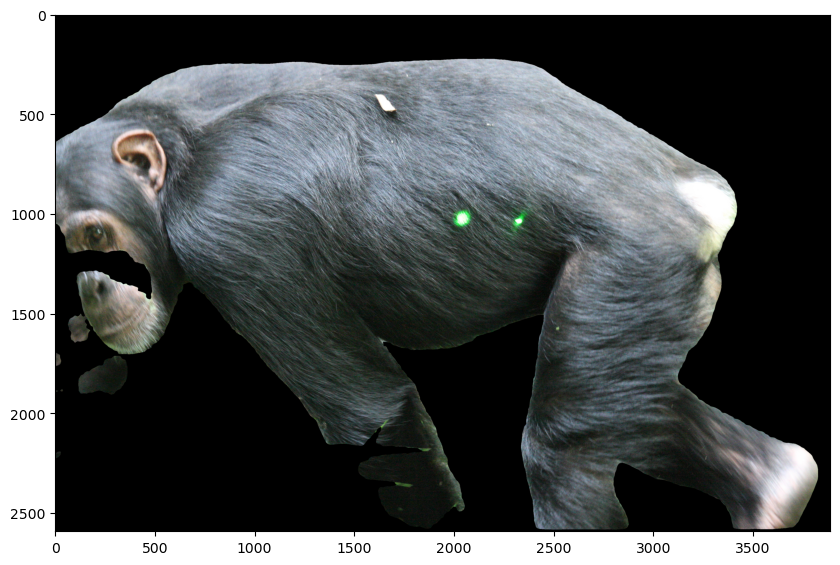

In [24]:
# get best mask
best_mask = masks[0]
output = np.zeros_like(img)
output[best_mask] = img[best_mask]

# show result
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()

Use segmented image to run laser detection algorithm

In [15]:
from skimage.feature import blob_log

In [16]:
original_img = img
img = output
hsv_frame = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert from BGR to HSV 

low_green = np.array([55, 110, 110])  #low_green values for green mask
high_green = np.array([65, 255, 255]) #high_green values for green mask
green_mask = cv2.inRange(hsv_frame, low_green, high_green) #performs basic threshold
green = cv2.bitwise_and(img, img, mask=green_mask)#performs bitwise and operation

#plt.imshow(green)
g = green[:,:,1] #extracts the green channel
# green = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)
#ret, thresh = cv2.threshold(g, 220,255,cv2.THRESH_BINARY)
blur = cv2.GaussianBlur(g,(25,25),0) #adds blurring for smoothing
ret3,thresh = cv2.threshold(blur,210,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #thresholding technique - pixel values <210 turn to 0, pixel values >210 turn to 255

#ret, thresh = cv2.threshold(g, 250,255,cv2.THRESH_BINARY) testing a different thresholding technique
#th3 = cv2.dilate(thresh,(5,5),iterations=35)


thresh = cv2.dilate(thresh,(5,5),iterations=28) #adds dilation to enlarge dots a bit can be tuned with the arguments

#thresh = cv2.dilate(thresh,(5,7),iterations=35)
# plt.imshow(thresh, cmap='gray')
# fig, ax = plt.subplots(1,2,figsize=(10,5))
#ax[0].set_title('Binary Thresholding',fontsize=15)
#ax[0].imshow(thresh,cmap='gray')



blobs = blob_log(thresh, max_sigma=50, threshold=0.15) # blob detection
count =0
if blobs.size != 0:  #checks if a blob was found
    # ax[1].imshow(thresh, cmap='gray')
    for blob in blobs[:2,:]:
        y, x, area = blob
        if area>1:   #checks for area of blob
            
            count +=1

            result1 = cv2.circle(original_img, (int(x),int(y)),12,(0,0,255),-1) # draws circles on detected blob

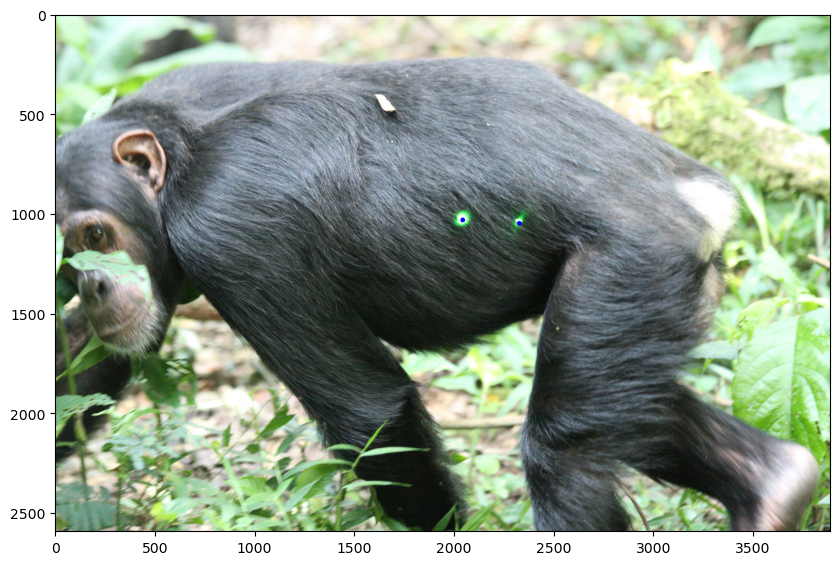

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(result1)
plt.show()

Let's test segmenting with box approach

In [20]:
print(original_img.shape)

(2592, 3888, 3)


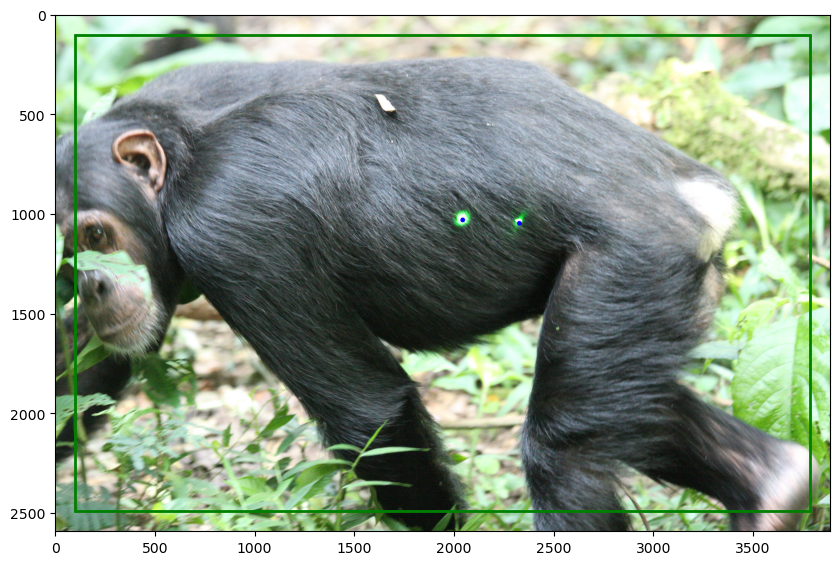

In [28]:
input_box = np.array([100, 100, 3788, 2492])
plt.figure(figsize=(10,10))
plt.imshow(original_img)
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

In [29]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

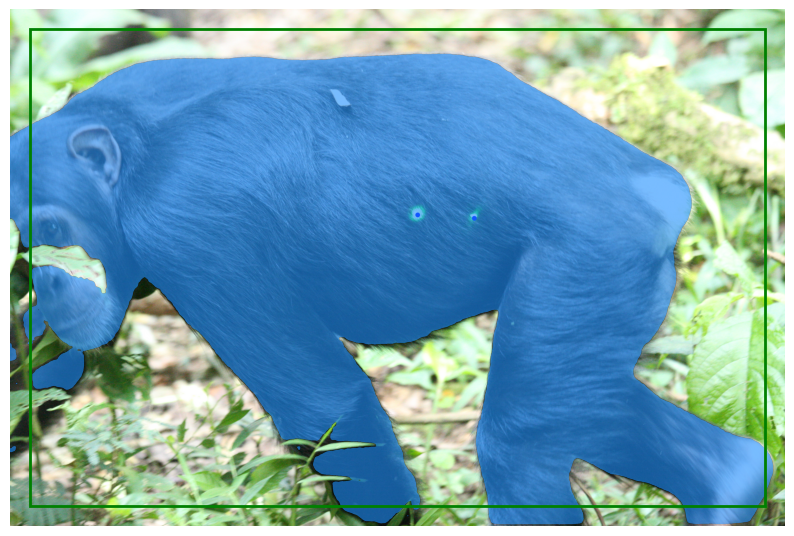

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(original_img)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()